# Logistic Regression on Yelp Reviews

In this exercise, we will try to predict the number of stars of a yelp review given the review text.

This sort of model can be very valuable out in the wild for many reasons. Firstly, it can be used to understand the kind of language being used in reviews. By using a white-box model, such as logistic regresion, we can understand which features (in this case which words) contribute most to a high or low rating. This could be used to help design subsequent language models or as a direct application to help business owners understand important reasons why they are getting high/low ratings.

With this lesson, you will learn:
1. How to prepare a text dataset
2. How to inspect text vectorizations
3. How to create a regression model
4. How to inspect performance of the model
5. How to inspect real-world impact of the model's performance

## Installation

To install the requirements for this notebook, run:

```
$ pip install pandas numpy matplotlib seaborn sklearn
```

## Imports

We start by importing our standard toolkit and defining some poperties of this notebook to render nicer plots

In [1]:
%matplotlib inline
import seaborn as sns
from IPython.core.pylabtools import figsize
figsize(14, 7)

In [2]:
import pandas as pd
import numpy as np
import pylab as py

## Loading Data

Next we load the dataset. The review dataset is quite large, so we downsample to 100,000 randomly picked reviews. This'll help our analysis go faster. You are encouraged to re-try these experiments with the full dataset. How do the results change as more data is used? How do the results change if _less_ data is used?

In [3]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("/data/datasets/social/yelp/yelp_review.csv").sample(100000)
data_train, data_test = train_test_split(
    data, 
    test_size=0.20,
    random_state=42
)

In [4]:
data.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
1875665,wpKyVKgU0_mPMprivMgT1A,5jSXrUAK_Gg9LhFrZow3YQ,juZR1DVWOZcdrYE4YFPvNw,5,2016-12-22,I was terrified to see what my car would look ...,0,0,0
4059934,Ne1J6yRwqBB2i0ZeepqCdA,QhoXP8jCk6WsXadVoxHI6w,6pQ1DpZo6zygNc3qTch-iA,5,2015-06-10,This coffee shop has my heart. The baristas ar...,0,0,0
1385777,5NFGFaPucShau0rGow0tBA,qBLPQLeitJxGQDhgLrDvAw,uAAWlLdsoUf872F1FKiX1A,5,2015-09-03,They have a generous amount of flavour of ice ...,0,0,0
3435781,RVHfoP7OL5N3q4m4xczWmQ,dyoYbLQItgMU7Q3P7sK4gQ,6JKiD0plaICGZ3zm2WPLBQ,1,2017-01-31,My mother in law went in and saw fake made in ...,2,4,0
2094863,Aw0lVla2Rds_2k1jSgLbpw,5FAD2Yq7DLBQ_-ef1iDA-A,nfon786ZkZzzgJwI_8hZXQ,5,2016-04-17,Gave Sunrise Donuts a try today and I have to ...,1,1,2


In [5]:
data.describe()

,stars,useful,funny,cool
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.725980,1.401000,0.501400,0.583570
std,1.432646,5.605613,2.350862,2.318157
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000,1.000000
max,5.000000,1341.000000,307.000000,204.000000


We'd like to create a model that inputs a review text and predicts the number of stars that review gave the business. First thing to do is to check the dataset to see if there is a class imbalance within our dataset.

1. If there is a class imbalance, how would you address this?
2. What other sorts of biases can you imagine in this dataset?
  - How would you address those issues?

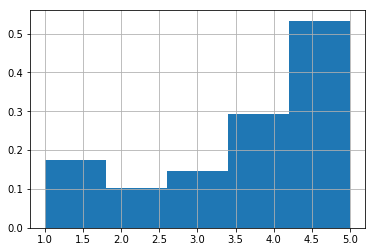

In [6]:
data.stars.hist(bins=5, density=True);

... DESCRIBE MODEL

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

tfidf = TfidfVectorizer(
    max_features=100000,
    ngram_range=(1, 2),
    max_df=2.0/3.0,
    binary=True
)
logit = LogisticRegression(
    class_weight='balanced',
    C=0.1
)
model = Pipeline([('tfidf', tfidf), ('logit', logit)])

In [8]:
model.fit(data_train.text, data_train.stars)
score = model.score(data_test.text, data_test.stars)

print(f"Model Score: {score*100}% accuracy")

Model Score: 64.845% accuracy


MOTIVATE CONFUSION MATRIX OVER ACCURACY

In [9]:
from sklearn.metrics import confusion_matrix

def create_confusion(model, data):
    pred = model.predict(data.text)
    confusion = confusion_matrix(data.stars, pred)
    confusion = confusion / confusion.sum(axis=1)[:, np.newaxis]
    return confusion

def plot_confusion(confusion, ax=None):
    ax = ax or py.gca()
    p = sns.heatmap(confusion, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5],
                    square=True, annot=True, ax=ax)
    ax.set_xlabel('Predicted Stars')
    ax.set_ylabel('True Stars')
    return p

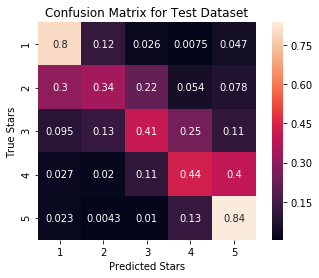

In [10]:
confusion = create_confusion(model, data_test)
plot_confusion(confusion)
py.title("Confusion Matrix for Test Dataset");

What are the most important words for each classification? Do they make sense? How do you think this contributes to the results you see from the model?

In [11]:
index_to_word = sorted(tfidf.vocabulary_, key=tfidf.vocabulary_.get)
n_words = 10
most_important_words = np.argpartition(logit.coef_, -n_words, axis=-1)[:, -n_words:]

print("Most important words")
for i, class_words in enumerate(most_important_words):
    print(f"{i+1} stars:", ", ".join(index_to_word[w] for w in class_words))

Most important words
1 stars: money, the worst, told, worst, rude, terrible, never, not, no, horrible
2 stars: was not, however, two stars, but, disappointed, disappointing, ok, not, mediocre, bland
3 stars: nothing, not, was good, average, okay, good, however, decent, but, ok
4 stars: great, enjoyed, good, but, bit, pretty, little, very good, nice, tasty
5 stars: delicious, love, great, recommend, highly, highly recommend, amazing, the best, best, awesome


## Understanding impacts of our model

We see that our model has fairly good performance. However, are these results evenly distributed across all groups?

1. Load in and merge the review dataset with information about the businesses
2. Inspect how the model accuracy varies across different business properties
3. Visualize results to highlight potential problems

In [12]:
data_business = pd.read_csv("/data/datasets/social/yelp/yelp_business.csv")
data_test = data_test.merge(data_business, on='business_id', suffixes=('', '_business'))
del data_business

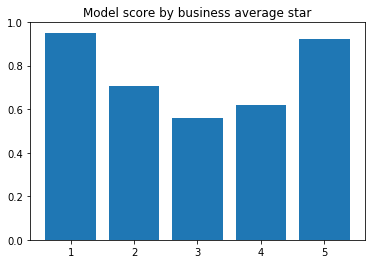

In [13]:
scores = []
for star in range(1, 6):
    d = data_test[data_test.stars_business == star]
    scores.append(model.score(d.text, d.stars))
py.title("Model score by business average star")
py.bar(range(1, 6), scores);

/home/micha/projects/acm_paper_2018/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


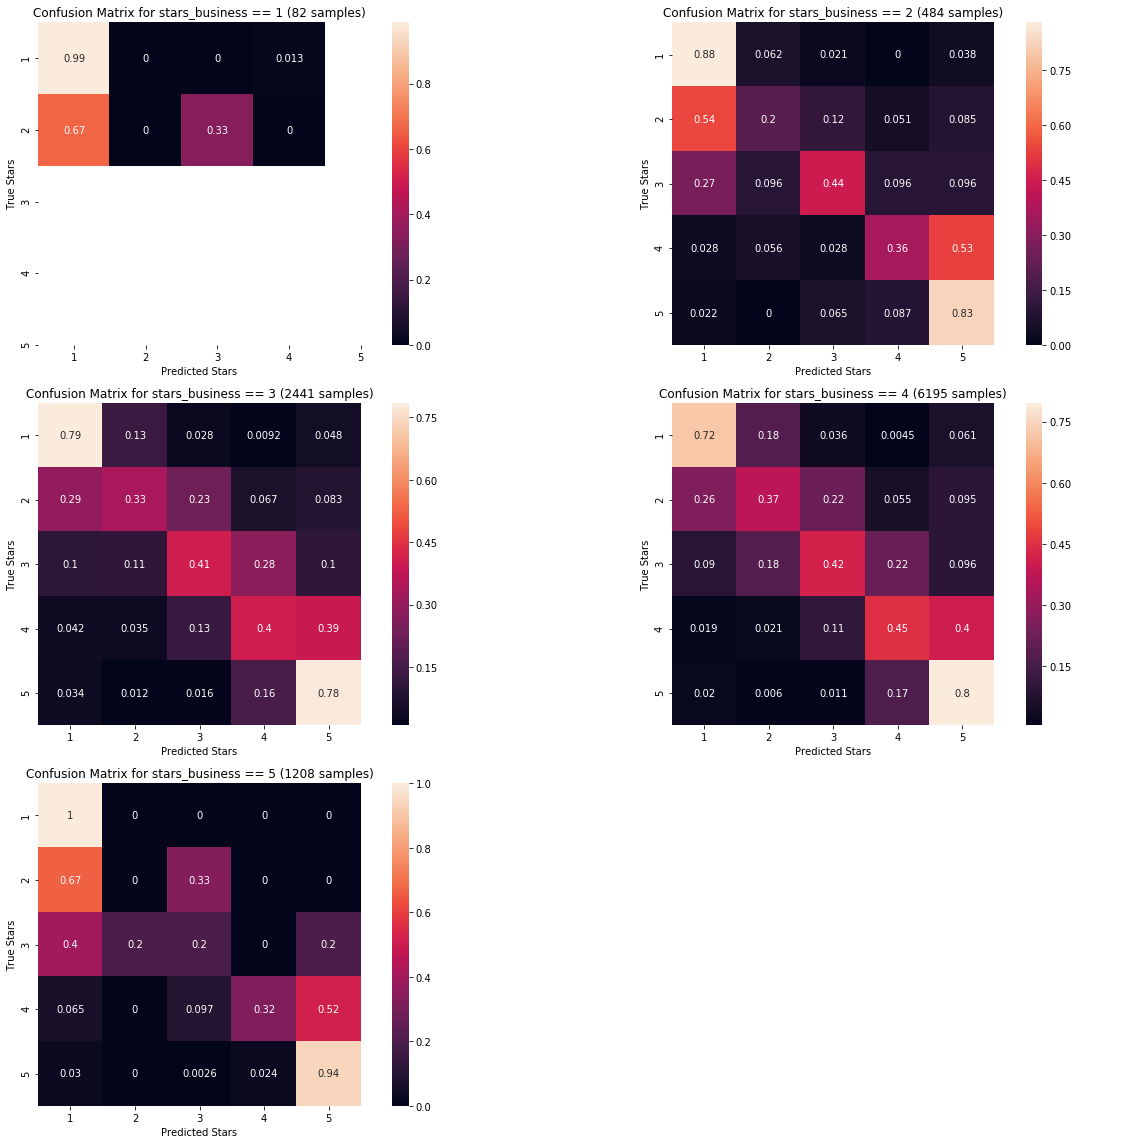

In [14]:
fig, axs = py.subplots(nrows=3, ncols=2, figsize=(18, 16))
for i, ax in zip(range(5), axs.reshape(-1)):
    stars = i + 1
    d = data_test.query(f'stars_business == {stars}')
    confusion = create_confusion(model, d)
    plot_confusion(confusion, ax=ax)
    ax.set_title(f"Confusion Matrix for stars_business == {stars} ({d.shape[0]} samples)")
axs.reshape(-1)[-1].axis('off')
fig.tight_layout();

We can see some strange behaviour for reviews on companies with an average of 2 and 5 stars. Note that the confusion matrix for businesses with 1 star is truncated because we only have 95 samples for that set, all of which represent reviews of 1 or 2 stars.

----

### Going Deeper

Can you find other aspects of a business or a reviewer that correlate to the model's behaviour? Explore this and visualize your results. What implications does this have around the real world impacts of this model?

In [15]:
categories = set(cat for cats in data_test.categories.values for cat in cats.split(';'))

In [16]:
category_scores = {}
category_min_samples = 50
for cat in categories:
    d = data_test[data_test.categories.str.contains(cat, regex=False)]
    if d.shape[0] > category_min_samples:
        category_scores[cat] = {'score': model.score(d.text, d.stars),
                                'data': d}

In [17]:
category_scores_sort = sorted(category_scores.items(), key=lambda x: x[1]['score'])

Let's first see if the model's accuracy over a certain category is correlated to the number of samples in that category

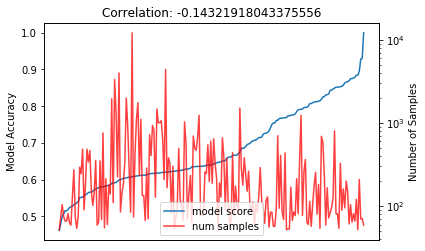

In [18]:
from scipy.stats import pearsonr

accuracy_by_category = [c[1]['score'] for c in category_scores_sort]
n_samples_by_category = [c[1]['data'].shape[0] for c in category_scores_sort]

lns1 = py.gca().plot(accuracy_by_category, label='model score')
py.ylabel("Model Accuracy")
ax2 = py.gca().twinx()
lns2 = ax2.semilogy(n_samples_by_category, c='r', label='num samples', alpha=0.75)
py.ylabel("Number of Samples")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
py.legend(lns, labs, loc='lower center')
py.xticks([], [])

correlation = pearsonr(accuracy_by_category, n_samples_by_category)[0]
py.title(f"Correlation: {correlation}");

Let's try manually inspecting the results and seeing if we can come up with external factors which may be contributing to this discrepancy.

In [19]:
print(f"Worst performing categories with > {category_min_samples} samples:")
for category, item in category_scores_sort[:25]:
    print(f"\t- {category} - Score: {item['score']*100:0.2f}% - "
          f"n_samples: {item['data'].shape[0]}")

Worst performing categories with > 50 samples:
	- Discount Store - Score: 46.15% - n_samples: 52
	- Fish & Chips - Score: 48.00% - n_samples: 75
	- Department Stores - Score: 50.00% - n_samples: 104
	- Men's Clothing - Score: 50.67% - n_samples: 75
	- Health Markets - Score: 51.52% - n_samples: 66
	- Amusement Parks - Score: 51.52% - n_samples: 66
	- Dive Bars - Score: 51.85% - n_samples: 81
	- Shopping Centers - Score: 52.38% - n_samples: 63
	- Museums - Score: 52.54% - n_samples: 59
	- Women's Clothing - Score: 52.80% - n_samples: 125
	- Grocery - Score: 53.11% - n_samples: 273
	- Irish - Score: 53.42% - n_samples: 73
	- Poke - Score: 53.70% - n_samples: 54
	- British - Score: 53.95% - n_samples: 76
	- Chicken Wings - Score: 55.10% - n_samples: 294
	- Vietnamese - Score: 55.10% - n_samples: 245
	- Sports Bars - Score: 55.26% - n_samples: 485
	- Drugstores - Score: 55.56% - n_samples: 90
	- Dance Clubs - Score: 55.91% - n_samples: 186
	- Pubs - Score: 56.11% - n_samples: 483
	- Buffet

In [20]:
print(f"Best performing categories with > {category_min_samples} samples:")
for category, item in category_scores_sort[-25:]:
    print(f"\t- {category} - Score: {item['score']*100:0.2f}% - "
          f"n_samples: {item['data'].shape[0]}")

Best performing categories with > 50 samples:
	- Medical Spas - Score: 83.33% - n_samples: 72
	- Massage Therapy - Score: 84.34% - n_samples: 83
	- Barbers - Score: 84.38% - n_samples: 96
	- General Dentistry - Score: 84.68% - n_samples: 124
	- Home Services - Score: 84.91% - n_samples: 802
	- Pet Sitting - Score: 85.19% - n_samples: 81
	- Plumbing - Score: 85.19% - n_samples: 81
	- Real Estate Services - Score: 85.19% - n_samples: 54
	- Hair Removal - Score: 85.32% - n_samples: 327
	- Veterinarians - Score: 85.39% - n_samples: 89
	- Eyelash Service - Score: 85.71% - n_samples: 161
	- Cosmetic Dentists - Score: 86.32% - n_samples: 95
	- Waxing - Score: 86.50% - n_samples: 200
	- Dentists - Score: 86.67% - n_samples: 150
	- Body Shops - Score: 86.89% - n_samples: 61
	- Hair Stylists - Score: 87.50% - n_samples: 104
	- Surgeons - Score: 87.50% - n_samples: 64
	- Makeup Artists - Score: 87.65% - n_samples: 81
	- Movers - Score: 87.88% - n_samples: 66
	- Contractors - Score: 88.43% - n_sam